In [2]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense, merge, CuDNNLSTM

Using TensorFlow backend.


In [3]:
# load csv data for input and output
validationSplit = 0.1

# 7 columns each for joint angles, angular velocities and angular acceleraions
uVec = pd.read_csv("Sarcos.csv", usecols=np.arange(21),  header=None,
                  names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 
                           'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7'])
# 7 columns for joint torques
yVec = pd.read_csv("Sarcos.csv", usecols=np.arange(21, 28, 1), header=None, 
                  names = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])

# to numpy array, 
# u.shape = (nDatapoints, 21, 1)
# y.shape = (nDatapoints, 7)
u = uVec.values[:, :, np.newaxis]
y = yVec.values[:, :]#, np.newaxis]

# normalize input data
uMean = np.mean(u, axis = 0)
uMax = np.amax(u, axis = 0)
u = (u-uMean)/uMax

# split into training and test data
valSplit = round(len(uVec)*validationSplit)
uTrain = u[0:-valSplit, :, :]
yTrain = y[0:-valSplit, :]
uTest = u[-valSplit+1:-1, :, :]
yTest = y[-valSplit+1:-1, :]

nInputs = uTest.shape[1]
nOutputs = yTest.shape[1]

Train on 36032 samples, validate on 4004 samples
Epoch 1/5
36032/36032 [==============================] - 160s 4ms/step - loss: 68.9174 - acc: 0.7728 - val_loss: 22.9933 - val_acc: 0.8442
Epoch 2/5
36032/36032 [==============================] - 157s 4ms/step - loss: 27.1167 - acc: 0.8452 - val_loss: 18.0314 - val_acc: 0.8634
Epoch 3/5
36032/36032 [==============================] - 158s 4ms/step - loss: 16.1303 - acc: 0.8849 - val_loss: 17.4324 - val_acc: 0.8744
Epoch 4/5
36032/36032 [==============================] - 158s 4ms/step - loss: 11.6874 - acc: 0.9009 - val_loss: 12.8001 - val_acc: 0.8819
Epoch 5/5
36032/36032 [==============================] - 158s 4ms/step - loss: 9.2281 - acc: 0.9107 - val_loss: 11.8193 - val_acc: 0.8846
Train on 36032 samples, validate on 4004 samples
Epoch 1/5
36032/36032 [==============================] - 162s 4ms/step - loss: 49.4108 - acc: 0.8097 - val_loss: 12.6685 - val_acc: 0.8921
Epoch 2/5
36032/36032 [==============================] - 160s 4ms/ste

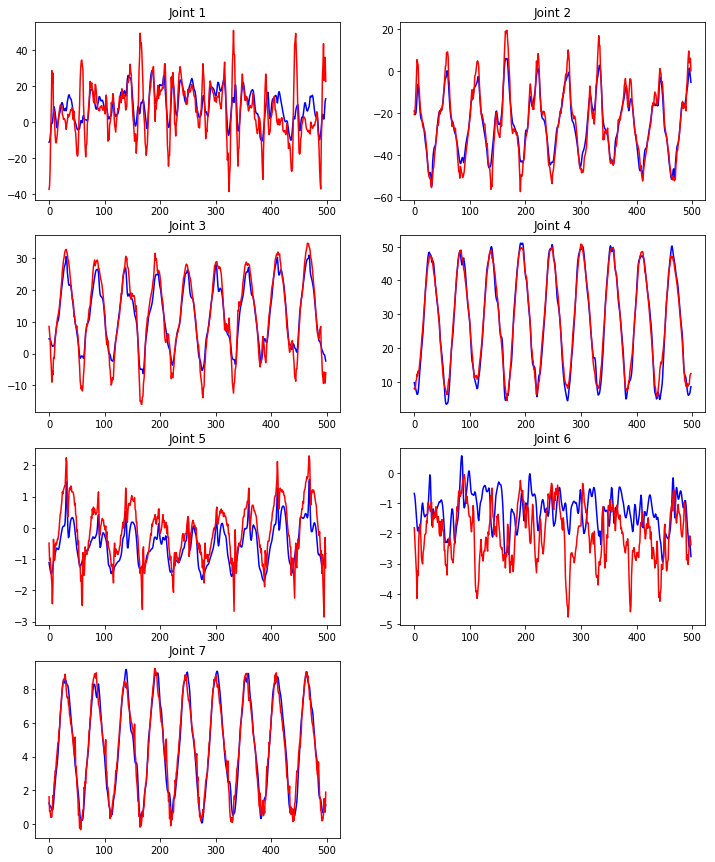

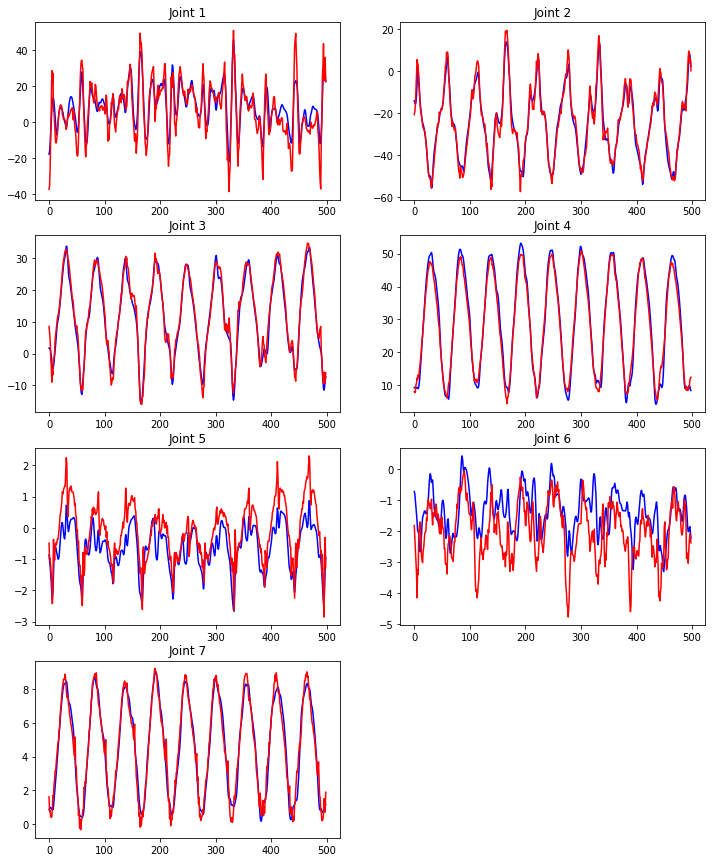

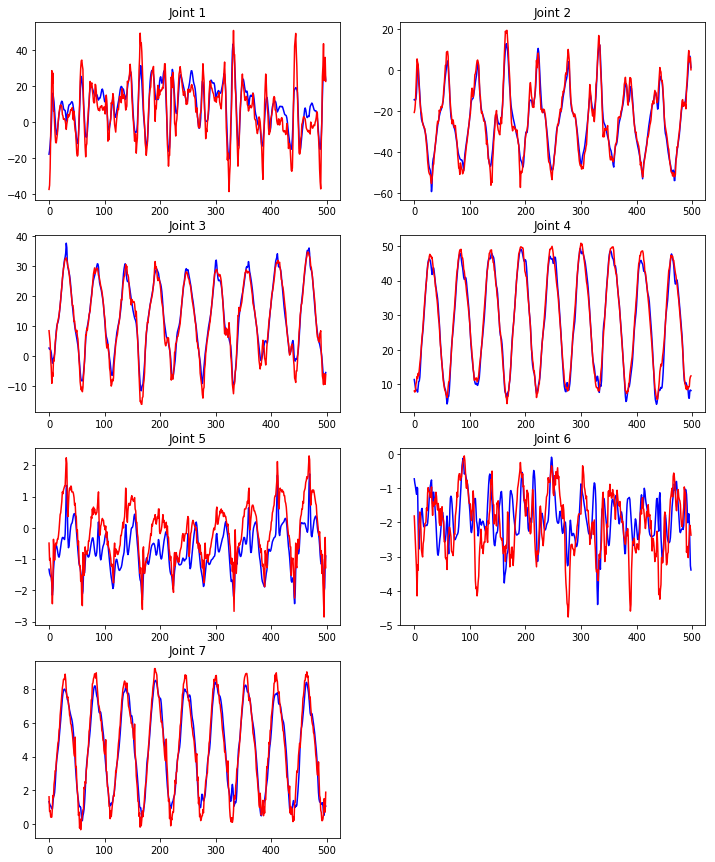

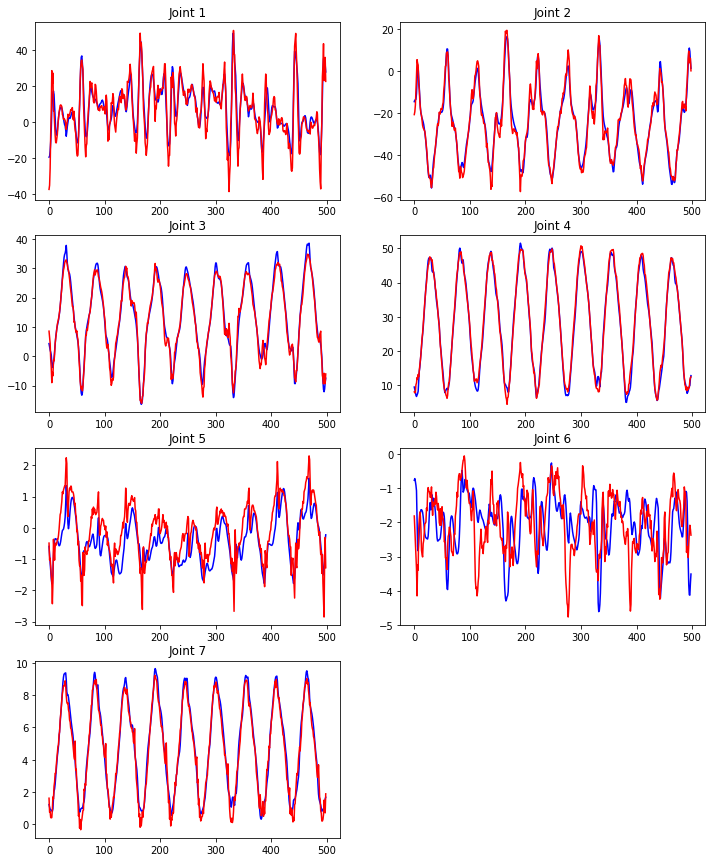

In [19]:

def generateNetwork(hiddenUnits, nInputs, nOutputs):
    # lstm with posibility to freezed reservioir weights
    main_input = Input(shape=(nInputs,1,), dtype='float', name='main_input')
    dense_one = Dense(nInputs, name="dense_one")(main_input) # names are added here
#    lstm_layer = LSTM(hiddenUnits, name='lstm_layer', return_sequences=True)(dense_one)
    lstm_layer2 = CuDNNLSTM(hiddenUnits, name='lstm_layer2', return_sequences=False)(dense_one)
    dense_two = Dense(hiddenUnits, name="dense_two")(lstm_layer2)
    dense_three = Dense(nOutputs, name="dense_three")(dense_two)
    model = Model(inputs=[main_input], outputs=[dense_three])
    return model

hiddenUnits = [32, 64, 128, 256]
error_joint = []
error_avg = []
# compile and train
for i in hiddenUnits:
    model = generateNetwork(i, nInputs, nOutputs)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(uTrain, yTrain, batch_size=1, epochs=5, validation_split = 0.1)

    # test on other dataset
    yPred = model.predict(uTest)
    
    # calcualte error
    nSamples = yTest.shape[0]
    sigma = np.var(yTest,axis=0)
    es = (yPred-yTest)**2
    error_joint.append(1/(sigma*nSamples)*np.sum(es,axis=0))
    error_avg.append(np.mean(es))

    # plot prediction reulsts
    length = -500
    plt.figure(figsize=(12,15))
    for j in range(1,8):
        plt.subplot(420+j)
        plt.plot(yPred[length:-1,j-1],'b')
        plt.plot(yTest[length:-1,j-1],'r')
        plt.title('Joint {}'.format(j))

[0.00964353 0.00110806 0.00040697 0.00039089 0.00011877 0.00024504
 0.00014297]
0.0017223164708447365


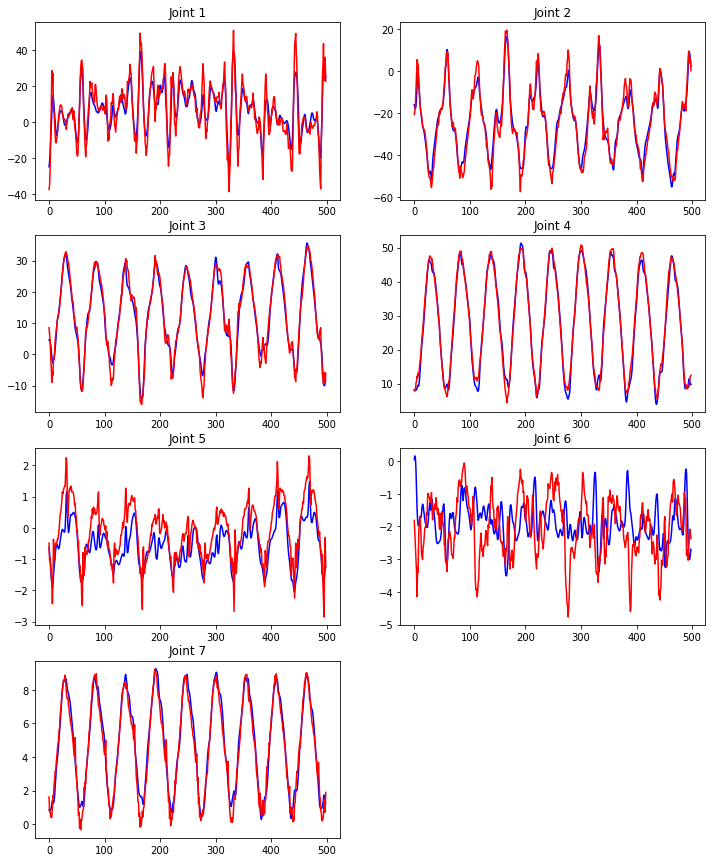

In [68]:
# test network
yPredBasic = model.predict(uTest)

# print error
m = np.argmax(np.abs(yTest), axis=0)
p = yPredBasic/m
t = yTest/m
e = np.abs(p-t)
error_joints = np.mean(e, axis=0)
error_avg = np.mean(error_joints)
print(error_joints)
print(error_avg)

# plot results, only last length samples
length = -500
plt.figure(figsize=(12,15))
for j in range(1,8):
    plt.subplot(420+j)
    plt.plot(yPredBasic[length:-1,j-1],'b')
    plt.plot(yTest[length:-1,j-1],'r')
    plt.title('Joint {}'.format(j))

4446/4446 [==============================] - 1s 326us/step
[1.15826483e-02 1.28483776e-03 4.97653968e-04 6.78302413e-04
 7.02044117e-05 2.39030609e-04 2.11036172e-04]
0.0020805305132418884


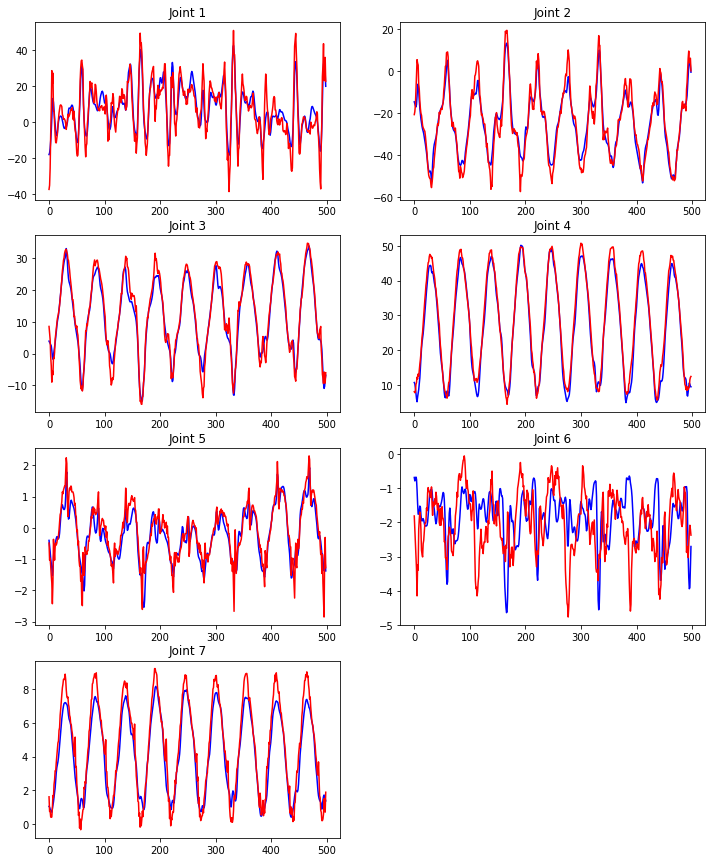

In [70]:
# freeze lstm layers to enable quicker update 
layer_to_freeze = model.get_layer("lstm_layer") # Get the layer you want to freeze
layer_to_freeze.trainable = False # Force not to update layer params
layer_to_freeze = model.get_layer("lstm_layer2") # Get the layer you want to freeze
layer_to_freeze.trainable = False # Force not to update layer params

# compile network again
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

yPred = model.predict(uTest, verbose=1)

# print error
m = np.argmax(np.abs(yTest), axis=0)
p = yPred/m
t = yTest/m
e = np.abs(p-t)
error_joints = np.mean(e, axis=0)
error_avg = np.mean(error_joints)
print(error_joints)
print(error_avg)

# plot results 
length = -500
plt.figure(figsize=(12,15))
for j in range(1,8):
    plt.subplot(420+j)
    plt.plot(yPred[length:-1,j-1],'b')
    plt.plot(yTest[length:-1,j-1],'r')
    plt.title('Joint {}'.format(j))